In [149]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
## fix control
## only enable flow control when mixing valve(s) are open (what if only one is open?)
## split cases - with only 1 thruster active, can use simple control... or does complex control reduce to simple one?
## simulate with variable heat
## tune separately..?

In [151]:
from datetime import datetime, timedelta
from control.modules.thrusters import (
    ThrustersAlarms,
    ThrustersControl,
    ThrustersParameters,
)
from input_output.base import Stamped
from input_output.definitions.simulation import (
    Boundary,
    Pcs,
    TemperatureBoundary,
    Thruster,
)
from input_output.modules.thrusters import (
    ThrustersControlValues,
    ThrustersSensorValues,
    ThrustersSimulationInputs,
    ThrustersSimulationOutputs,
)
from orchestration.simulator import Simulator, SimulatorModel
from simulation.models.fmu_paths import thrusters_path

start_time = datetime.fromtimestamp(0)
# duration = timedelta(minutes=49)
# time_index = pl.datetime_range(
#     start_time, start_time + duration, interval="1m", time_unit="us", eager=True
# )

# thrusters_pcs = StampedDf.stamp(
#     pl.DataFrame(
#         {
#             "time": time_index,
#             "value": 2 * ["off"] + 38 * ["propulsion"] + 10 * ["maneuvering"],
#         },
#     )
# )

# supply_temperature = StampedDf.stamp(
#     pl.DataFrame({"time": time_index, "value": 20 * [60.0] + 30 * [85.0]})
# )
# fwd_thruster_active = StampedDf.stamp(
#     pl.DataFrame({
#         "time": time_index,
#         "value": 2 * ["False"] + 28 * ["True"] + 20 * ["False"],
#     })
# )
# fwd_thruster_heat = StampedDf.stamp(
#     pl.DataFrame({"time": time_index, "value": 2 * [0.0] + 28 * [4300.0] + 20 * [0]})
# )

# aft_thruster_heat = StampedDf.stamp(
#     pl.DataFrame({"time": time_index, "value": 2 * [0.0] + 48 * [9000.0]})
# )

simulation_inputs = ThrustersSimulationInputs(
    thrusters_aft=Thruster(heat_flow=Stamped.stamp(9000), active=Stamped.stamp(True)),
    thrusters_fwd=Thruster(heat_flow=Stamped.stamp(4000), active=Stamped.stamp(False)),
    thrusters_seawater_supply=Boundary(
        temperature=Stamped.stamp(32.0), flow=Stamped.stamp(10.0)
    ),
    thrusters_module_supply=TemperatureBoundary(temperature=Stamped.stamp(30)),
    thrusters_pcs=Pcs(mode=Stamped.stamp('propulsion')),
)

control = ThrustersControl(ThrustersParameters(recovery_mix_target_temperature=40, recovery_flow_target_temperature=60, flowcontrol_valve_target_position=.95)
                           )

thrusters_model = SimulatorModel(
    fmu_path=thrusters_path,
    sensor_values_cls=ThrustersSensorValues,
    control_values_cls=ThrustersControlValues,
    simulation_outputs_cls=ThrustersSimulationOutputs,
    simulation_inputs=simulation_inputs,
    control=control,
    alarms=ThrustersAlarms(),
    tick_duration=timedelta(seconds=1),
    start_time=start_time,
)

with thrusters_model.executor() as executor:
    simulation = Simulator(thrusters_model, executor)

    result = await simulation.run(1000)


/Users/alje/Repos/zero-thrs-control/src/orchestration/collector.py:25: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  self._data.vstack(pl.DataFrame({**values, 'time': time, 'control_mode': control_mode}, schema_overrides = self._schema, strict = False), in_place=True)


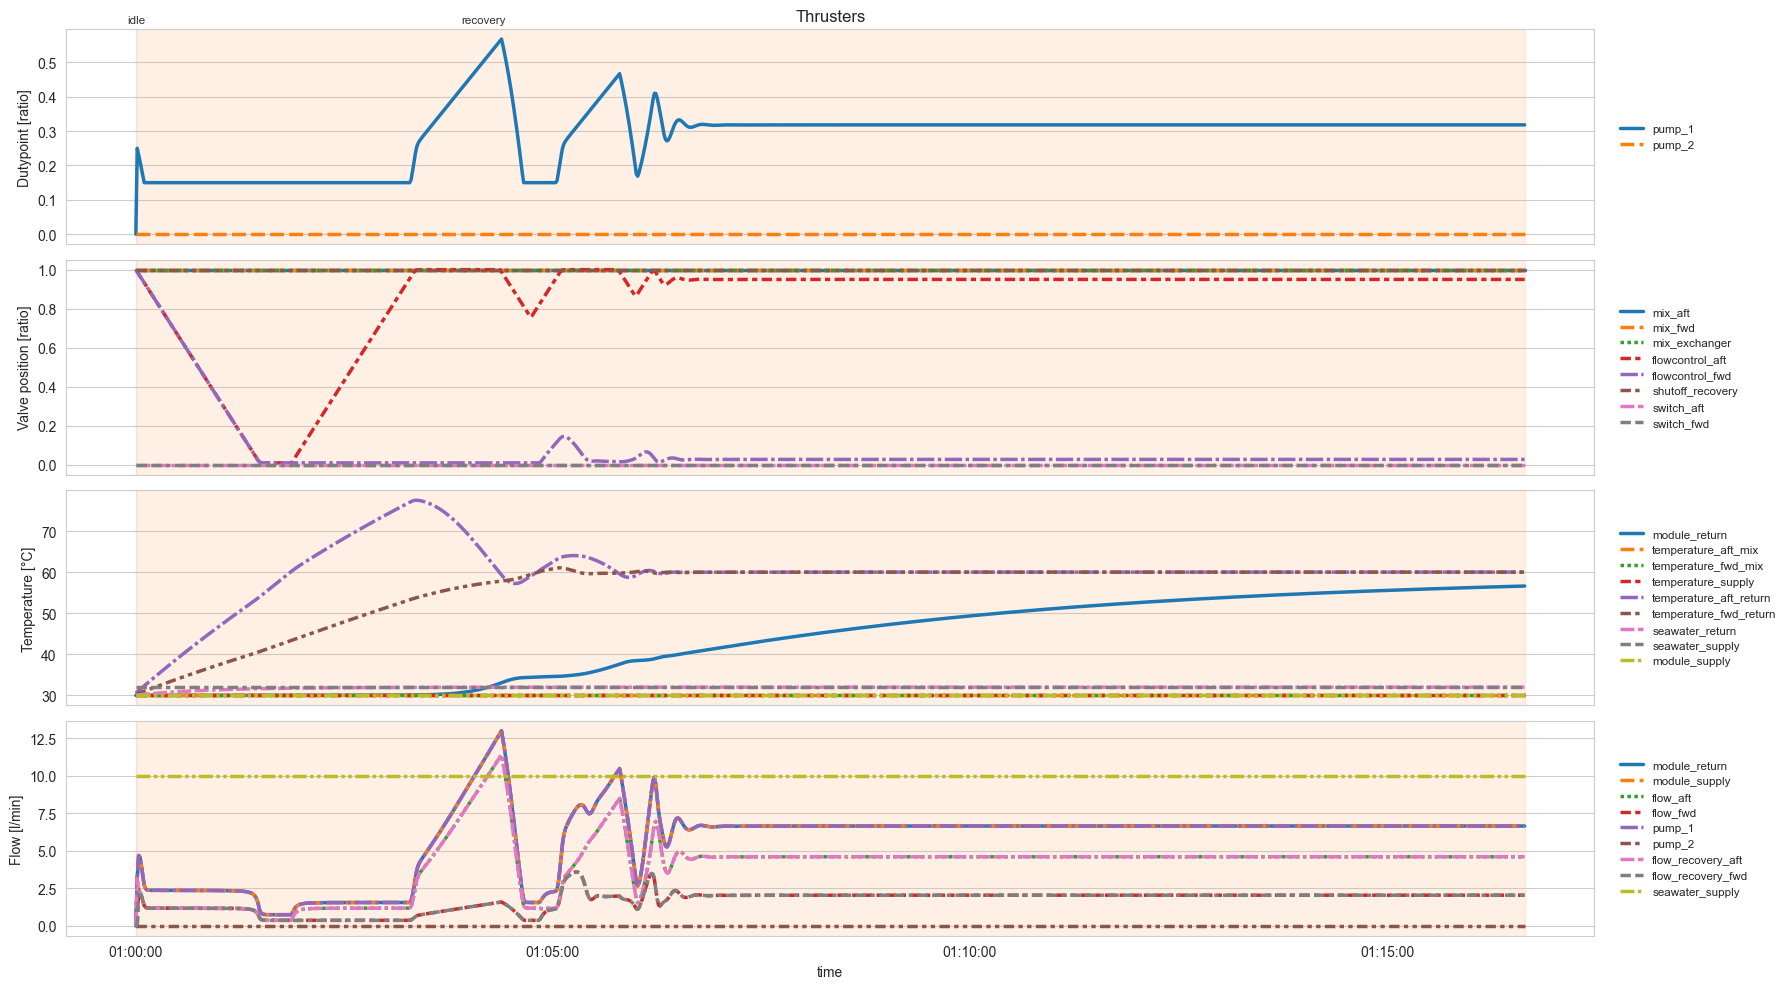

In [152]:
from analysis.analysis_utils import plot_result


plot_result(result, "test");